# Title: Document Classification with BERT-based Embeddings


In [8]:
# Import necessary libraries
import json
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from collections import Counter

## Load and Preprocess the Data

In [10]:
# Load and preprocess the document data
file_path = 'outputs/extracted_information.json'  # Replace with your file path

# Load the data from JSON
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Preprocess the text data
def preprocess_text(text):
    if isinstance(text, str):
        text = text.strip().lower()  # Example preprocessing steps
    return text

# Apply preprocessing to the documents
for entry in data['tables']:
    entry['Title'] = preprocess_text(entry.get('Title', ''))
    entry['Abstract'] = preprocess_text(entry.get('Abstract', ''))
    entry['Keywords'] = preprocess_text(entry.get('Keywords', ''))


## Generate Embeddings Using Fine-tuned BERT

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load the fine-tuned BERT model and tokenizer
model_path = './fine_tuned_bert'  # Replace with your fine-tuned model path
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path)

# Function to generate embeddings for a given text using the fine-tuned BERT model
def generate_embedding(text):
    if not text:  # Check if the text is empty or None
        return np.zeros(768).tolist()  # Return a zero-vector of the appropriate size if text is missing

    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use mean pooling on the last hidden state to create the embedding
    embedding = torch.mean(outputs.last_hidden_state, dim=1).squeeze().tolist()
    return embedding

# Generate embeddings for each document and save with all information
document_embeddings = []
for entry in data['tables']:
    document_id = entry.get('ID', 'N/A')  # Assuming there's an ID field
    title = entry.get('Title', '')
    abstract = entry.get('Abstract', '')
    keywords = entry.get('Keywords', '')

    # Combine the Title, Abstract, and Keywords into a single text entry
    combined_text = ' '.join(filter(None, [title, abstract, keywords]))

    # Generate the embedding for the combined text
    combined_embedding = generate_embedding(combined_text)
    
    # Store the combined embedding with all document information
    entry['Combined_Embedding'] = combined_embedding
    document_embeddings.append(entry)



# Perform Clustering with K-Means

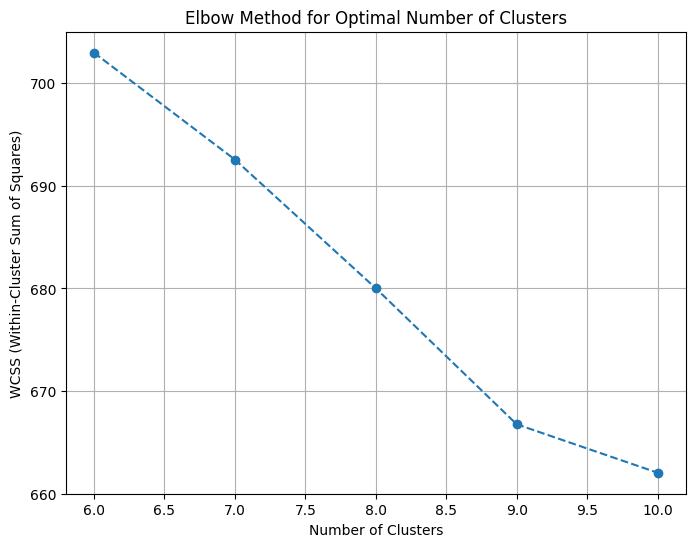

In [25]:
# Extract embeddings and perform clustering using K-Means
embeddings = np.array([entry['Combined_Embedding'] for entry in data['tables']])

# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for n_clusters in range(6, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(6, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

# Perform clustering with the optimal number of clusters
optimal_clusters = int(input("Enter the optimal number of clusters based on the Elbow graph: "))
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Store the cluster labels in the data
for idx, entry in enumerate(data['tables']):
    entry['Cluster_Label'] = int(cluster_labels[idx])


## Keyword Extraction Using LDA and TF-CDF

In [27]:
# Initialize the cluster_texts dictionary
cluster_texts = {i: [] for i in range(optimal_clusters)}

# Organize text data for each cluster
for entry in data['tables']:
    # Ensure that Title, Abstract, and Keywords are strings and handle None values
    title = entry['Title'] if entry['Title'] else ""
    abstract = entry['Abstract'] if entry['Abstract'] else ""
    keywords = entry['Keywords'] if entry['Keywords'] else ""

    # Combine the text data and append it to the appropriate cluster
    cluster_texts[entry['Cluster_Label']].append(' '.join([title, abstract, keywords]))

# Process each cluster's text data and apply LDA for keyword extraction
vectorizer = CountVectorizer(stop_words='english')
lda_keywords = {}

for cluster_label, texts in cluster_texts.items():
    X = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=1, random_state=42)
    lda.fit(X)
    terms = vectorizer.get_feature_names_out()
    topic = lda.components_[0]
    top_indices = topic.argsort()[-15:][::-1]
    lda_keywords[cluster_label] = [terms[i] for i in top_indices]

# Display extracted keywords for each cluster
for cluster, keywords in lda_keywords.items():
    print(f'Cluster {cluster}: Most Important Words - {", ".join(keywords)}')


Cluster 0: Most Important Words - letter, graph, table, stroke, model, supervised, kerning, recognition, learning, wise, document, set, method, saghog, running
Cluster 1: Most Important Words - text, document, dataset, table, data, model, recognition, information, analysis, datasets, layout, tables, models, annotation, approach
Cluster 2: Most Important Words - text, recognition, image, images, handwritten, data, historical, competition, oracle, dataset, handwriting, based, learning, answers, bone
Cluster 3: Most Important Words - documents, document, task, text, recognition, model, detection, based, dataset, multi, information, method, verification, data, reading
Cluster 4: Most Important Words - text, document, model, information, recognition, graph, extraction, performance, language, image, based, scene, semantic, multi, network
Cluster 5: Most Important Words - recognition, dataset, text, historical, information, handwritten, images, documents, models, data, task, analysis, century

## Match Each Cluster to Predefined Categories

In [35]:
from collections import Counter

# Predefined categories with associated keywords
categories = {
    "tables": {"table", "layout", "graph", "cell", "spreadsheet"},
    "classification": {"classification", "category", "predict", "label", "classifier"},
    "keyInformationExtraction": {"extraction", "task", "key", "information", "field"},
    "opticalCharacterRecognition": {"recognition", "text", "handwritten", "ocr", "character"},
    "datasets": {"dataset", "data", "competition", "image", "documents"},
    "layoutUnderstanding": {"document", "layout", "structure", "format", "content"},
    "others": set()  # To handle cases where none of the keywords match
}

cluster_keywords = lda_keywords  # Use the LDA-generated keywords from the previous analysis

# Function to calculate similarity scores between cluster keywords and categories
def calculate_similarity(cluster_keywords, category_keywords):
    overlap = len(set(cluster_keywords) & category_keywords)
    return overlap / len(category_keywords) if category_keywords else 0

# Dictionary to store the best-matching categories for each cluster
cluster_to_category = {}

# Step 3: Match each cluster to the predefined categories
for cluster_label, keywords in cluster_keywords.items():
    similarity_scores = {category: calculate_similarity(keywords, category_keywords) for category, category_keywords in categories.items()}
    sorted_categories = sorted(similarity_scores, key=similarity_scores.get, reverse=True)

    # Take the top 3 categories and if they don't match well, add "others"
    top_categories = sorted_categories[:3] if similarity_scores[sorted_categories[0]] > 0 else ["others"]
    cluster_to_category[cluster_label] = top_categories

# Step 4: Display the best matching categories for each cluster
for cluster_label, top_categories in cluster_to_category.items():
    print(f'Cluster {cluster_label}: Best Matching Categories - {", ".join(top_categories)}')


Cluster 0: Best Matching Categories - tables, opticalCharacterRecognition, layoutUnderstanding
Cluster 1: Best Matching Categories - tables, opticalCharacterRecognition, datasets
Cluster 2: Best Matching Categories - datasets, opticalCharacterRecognition, tables
Cluster 3: Best Matching Categories - datasets, keyInformationExtraction, opticalCharacterRecognition
Cluster 4: Best Matching Categories - keyInformationExtraction, opticalCharacterRecognition, tables
Cluster 5: Best Matching Categories - opticalCharacterRecognition, datasets, keyInformationExtraction
Cluster 6: Best Matching Categories - keyInformationExtraction, opticalCharacterRecognition, layoutUnderstanding
Cluster 7: Best Matching Categories - opticalCharacterRecognition, datasets, tables
Cluster 8: Best Matching Categories - opticalCharacterRecognition, datasets, tables


## Built the final json file

In [38]:
# Initialize the final structured JSON format
categorized_data = {
    "tables": [],
    "classification": [],
    "keyInformationExtraction": [],
    "opticalCharacterRecognition": [],
    "datasets": [],
    "layoutUnderstanding": [],
    "others": []
}

# Organize documents into the appropriate categories based on the cluster mapping
for entry in data['tables']:
    cluster = entry['Cluster_Label']
    top_category = cluster_to_category.get(cluster, ["others"])[0]  # Use the best-matching category or 'others'

    # Create the document entry for the category
    document_entry = {
        "originalFileName": entry.get('ID', 'Unknown'),  # Assuming 'ID' represents the original file name
        "title": entry.get('Title', 'No Title'),
        "authors": entry.get('Authors', [])
    }

    # Add the document to the correct category in the JSON structure
    categorized_data[top_category].append(document_entry)
    
# Save the organized data into a JSON file with the specified format
output_categorized_file_path = 'outputs/categorized_documents2.json'  # Replace with your desired file path

# Write the structured JSON data to the specified file
with open(output_categorized_file_path, 'w', encoding='utf-8') as f:
    json.dump(categorized_data, f, ensure_ascii=False, indent=4)

print(f"Categorized documents saved successfully to {output_categorized_file_path}")
# Display the final structured JSON
import pprint
pprint.pprint(categorized_data)


Categorized documents saved successfully to outputs/categorized_documents2.json
{'classification': [],
 'datasets': [{'authors': ['Silvia Cascianelli',
                           'Vittorio Pippi',
                           'Rita Cucchiara',
                           'Fabio Quattrini'],
               'originalFileName': '7',
               'title': 'binarizing documents by leveraging both space and '
                        'frequency'},
              {'authors': ['Askar Hamdulla',
                           'Mayire Ibrayim',
                           'Jianjun Kang',
                           'Chunhu Zhang',
                           'Mengmeng Chen'],
               'originalFileName': '16',
               'title': 'a real-time scene uyghur text detection network based '
                        'on feature complementation'},
              {'authors': ['M. Saquib Sarfraz',
                           'Rainer Stiefelhagen',
                           'Omar Moured',
                  